<a href="https://colab.research.google.com/github/lusgaoliveira/imputacao-de-dados-e-previsao-com-redes-neurais/blob/main/imputacao-de-dados-e-previsao-com-redes-neurais.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
import numpy as np

In [39]:
import pandas as pd

In [40]:
import matplotlib.pyplot as plt

In [41]:
import seaborn as sns

In [42]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [43]:
from tensorflow.keras.models import Sequential

In [44]:
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Bidirectional

In [45]:
from tensorflow.keras.optimizers import Adam

In [46]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [47]:
from tensorflow.keras.regularizers import l2

In [48]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [49]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Importando o dataset e tratando

> Add blockquote



In [50]:
fonte_dados = "github"  # ou "drive"

if fonte_dados == "drive":
    from google.colab import drive
    drive.mount('/content/drive')
    caminho_arquivo = "/content/drive/MyDrive/TCC/data/dados_dias.csv"
else:
    caminho_arquivo = "https://raw.githubusercontent.com/lusgaoliveira/imputacao-de-dados-e-previsao-com-redes-neurais/main/data/dados_dias.csv"

# Carrega os dados
data = pd.read_csv(caminho_arquivo, sep=";", skiprows=9)

In [51]:
data.columns

Index(['Data Medicao', 'PRECIPITACAO TOTAL, DIARIO (AUT)(mm)',
       'PRESSAO ATMOSFERICA MEDIA DIARIA (AUT)(mB)',
       'TEMPERATURA DO PONTO DE ORVALHO MEDIA DIARIA (AUT)(°C)',
       'TEMPERATURA MAXIMA, DIARIA (AUT)(°C)',
       'TEMPERATURA MEDIA, DIARIA (AUT)(°C)',
       'TEMPERATURA MINIMA, DIARIA (AUT)(°C)',
       'UMIDADE RELATIVA DO AR, MEDIA DIARIA (AUT)(%)',
       'UMIDADE RELATIVA DO AR, MINIMA DIARIA (AUT)(%)',
       'VENTO, RAJADA MAXIMA DIARIA (AUT)(m/s)',
       'VENTO, VELOCIDADE MEDIA DIARIA (AUT)(m/s)', 'Unnamed: 11'],
      dtype='object')

In [52]:
data = data.drop(columns=['Unnamed: 11'], errors='ignore')

In [53]:
# Renomear as colunas
data.columns = ['Data', 'PrecipitacaoTotalDiaria (AUT)(mm)', 'PressaoMediaDiaria (AUT)(mB)', 'TempPontoOrvalho (AUT)(°C)',
                'TempMaxima (AUT)(°C)', 'TempMedia (AUT)(°C)', 'TempMinima (AUT)(°C)', 'UmidadeMedia (AUT)(%)', 'UmidadeMinima (AUT)(%)',
                'VentoRajadaMaxima (AUT)(m/s)', 'VentoVelocidadeMedia (AUT)(m/s)']

In [54]:
data.head()

,Data,PrecipitacaoTotalDiaria (AUT)(mm),PressaoMediaDiaria (AUT)(mB),TempPontoOrvalho (AUT)(°C),TempMaxima (AUT)(°C),TempMedia (AUT)(°C),TempMinima (AUT)(°C),UmidadeMedia (AUT)(%),UmidadeMinima (AUT)(%),VentoRajadaMaxima (AUT)(m/s),VentoVelocidadeMedia (AUT)(m/s)
0,2009-06-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47.0,"8,9",NaN
1,2009-06-26,NaN,"986,7","18,2",29,"21,7",17,"80,4",50.0,"5,2","1,4"
2,2009-06-27,0,"988,4",19,28,"22,6","18,9","81,6",52.0,"7,6","1,7"
3,2009-06-28,0,"987,3","18,8",27,"21,9","19,2","83,5",55.0,"5,9","1,4"
4,2009-06-29,0,"985,3","18,4","28,5","22,3","18,6","80,8",48.0,"5,5","1,3"


In [55]:
# df["Data"] = pd.to_datetime(df["Data"])  # Converte para datetime
# df = df.set_index("Data")
# df = df.sort_index()

In [56]:
# Converter 'Data' para datetime e usar como índice
data['Data'] = pd.to_datetime(data['Data'], errors='coerce')
data = data.set_index('Data')
data = data.sort_index()

data.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5669 entries, 2009-06-25 to 2024-12-31
Data columns (total 10 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   PrecipitacaoTotalDiaria (AUT)(mm)  4531 non-null   object 
 1   PressaoMediaDiaria (AUT)(mB)       5098 non-null   object 
 2   TempPontoOrvalho (AUT)(°C)         5075 non-null   object 
 3   TempMaxima (AUT)(°C)               5108 non-null   object 
 4   TempMedia (AUT)(°C)                5057 non-null   object 
 5   TempMinima (AUT)(°C)               5109 non-null   object 
 6   UmidadeMedia (AUT)(%)              5137 non-null   object 
 7   UmidadeMinima (AUT)(%)             5293 non-null   float64
 8   VentoRajadaMaxima (AUT)(m/s)       5203 non-null   object 
 9   VentoVelocidadeMedia (AUT)(m/s)    5007 non-null   object 
dtypes: float64(1), object(9)
memory usage: 487.2+ KB


In [57]:
colunas_para_converter = [
    'PrecipitacaoTotalDiaria (AUT)(mm)', 'PressaoMediaDiaria (AUT)(mB)', 'TempPontoOrvalho (AUT)(°C)',
    'TempMaxima (AUT)(°C)', 'TempMedia (AUT)(°C)', 'TempMinima (AUT)(°C)', 'UmidadeMedia (AUT)(%)', 'UmidadeMinima (AUT)(%)',
    'VentoRajadaMaxima (AUT)(m/s)', 'VentoVelocidadeMedia (AUT)(m/s)'
]

In [58]:
# A grande maioria dos valores das colunas está usando "vírgula" e não ".". Essa função cuida da conversão para o formato correto
def remove_virgula(value):
    if isinstance(value, str):
        try:
            return float(value.replace(',', '.'))
        except ValueError:
            return value
    return value

In [59]:
for col in colunas_para_converter:
    data[col] = data[col].map(remove_virgula)

In [60]:
data.info()
print(data.isnull().sum())

data = data.fillna(data.select_dtypes(include=['number']).mean())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5669 entries, 2009-06-25 to 2024-12-31
Data columns (total 10 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   PrecipitacaoTotalDiaria (AUT)(mm)  4531 non-null   float64
 1   PressaoMediaDiaria (AUT)(mB)       5098 non-null   float64
 2   TempPontoOrvalho (AUT)(°C)         5075 non-null   float64
 3   TempMaxima (AUT)(°C)               5108 non-null   float64
 4   TempMedia (AUT)(°C)                5057 non-null   float64
 5   TempMinima (AUT)(°C)               5109 non-null   float64
 6   UmidadeMedia (AUT)(%)              5137 non-null   float64
 7   UmidadeMinima (AUT)(%)             5293 non-null   float64
 8   VentoRajadaMaxima (AUT)(m/s)       5203 non-null   float64
 9   VentoVelocidadeMedia (AUT)(m/s)    5007 non-null   float64
dtypes: float64(10)
memory usage: 487.2 KB
PrecipitacaoTotalDiaria (AUT)(mm)    1138
PressaoMediaDiaria (AU

## 2. Estatísticas

In [61]:
# Usar o DataFrame original (já tratadas)
df_eda = data.copy()

# Estatísticas descritivas
print("Resumo estatístico:")
print(df_eda.describe())

Resumo estatístico:
       PrecipitacaoTotalDiaria (AUT)(mm)  PressaoMediaDiaria (AUT)(mB)  \
count                        5669.000000                   5669.000000   
mean                            2.273317                    984.040624   
std                             6.800282                      3.011226   
min                             0.000000                    973.400000   
25%                             0.000000                    982.000000   
50%                             0.200000                    984.040624   
75%                             2.273317                    986.000000   
max                           123.400000                    994.300000   

       TempPontoOrvalho (AUT)(°C)  TempMaxima (AUT)(°C)  TempMedia (AUT)(°C)  \
count                  5669.00000           5669.000000          5669.000000   
mean                     18.30201             30.864742            24.207139   
std                       1.85753              3.123921             2.228

### 2.1 Histograma

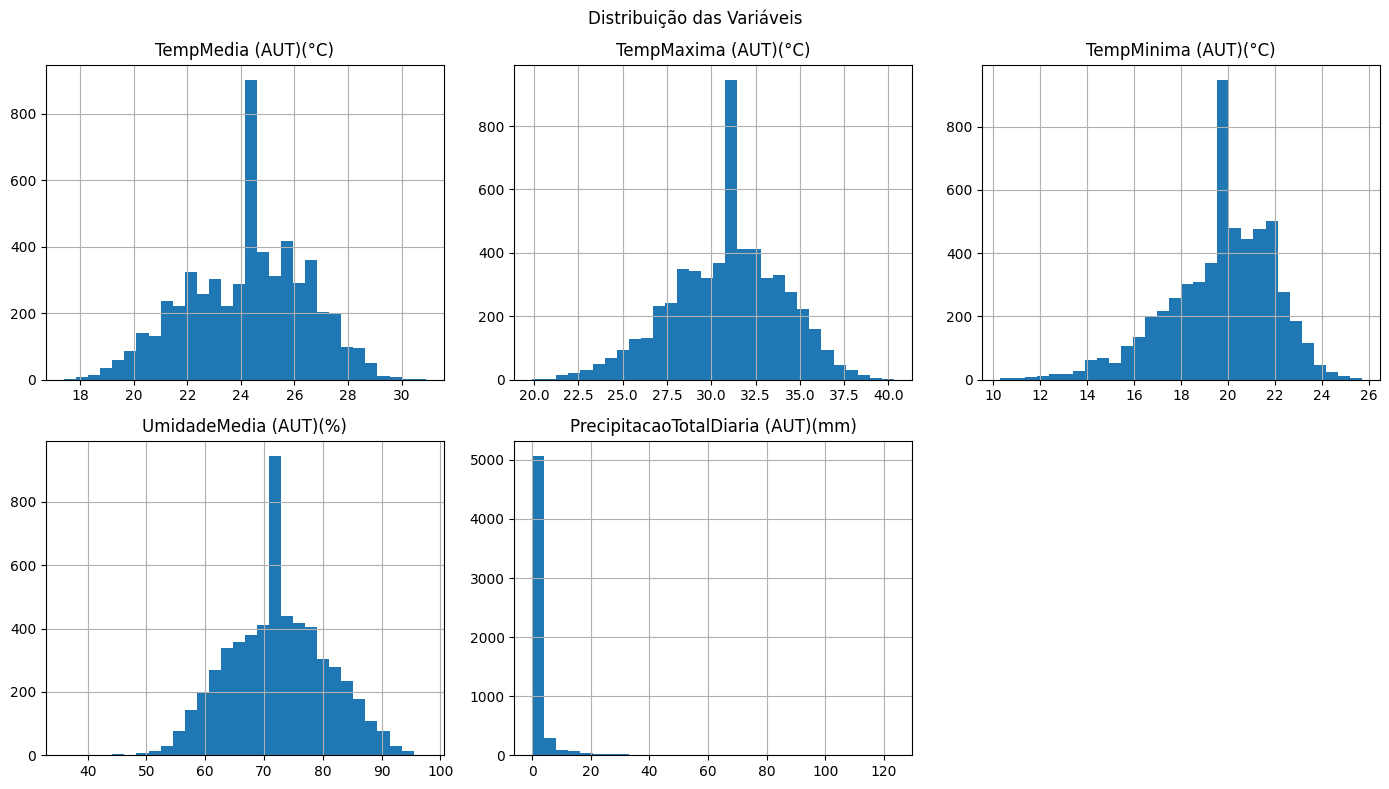

In [62]:
# Histograma das principais variáveis
variaveis_interesse = ['TempMedia (AUT)(°C)', 'TempMaxima (AUT)(°C)', 'TempMinima (AUT)(°C)',
                       'UmidadeMedia (AUT)(%)', 'PrecipitacaoTotalDiaria (AUT)(mm)']

df_eda[variaveis_interesse].hist(bins=30, figsize=(14, 8), layout=(2, 3))
plt.suptitle("Distribuição das Variáveis")
plt.tight_layout()
plt.show()

### 2.2 Boxplots

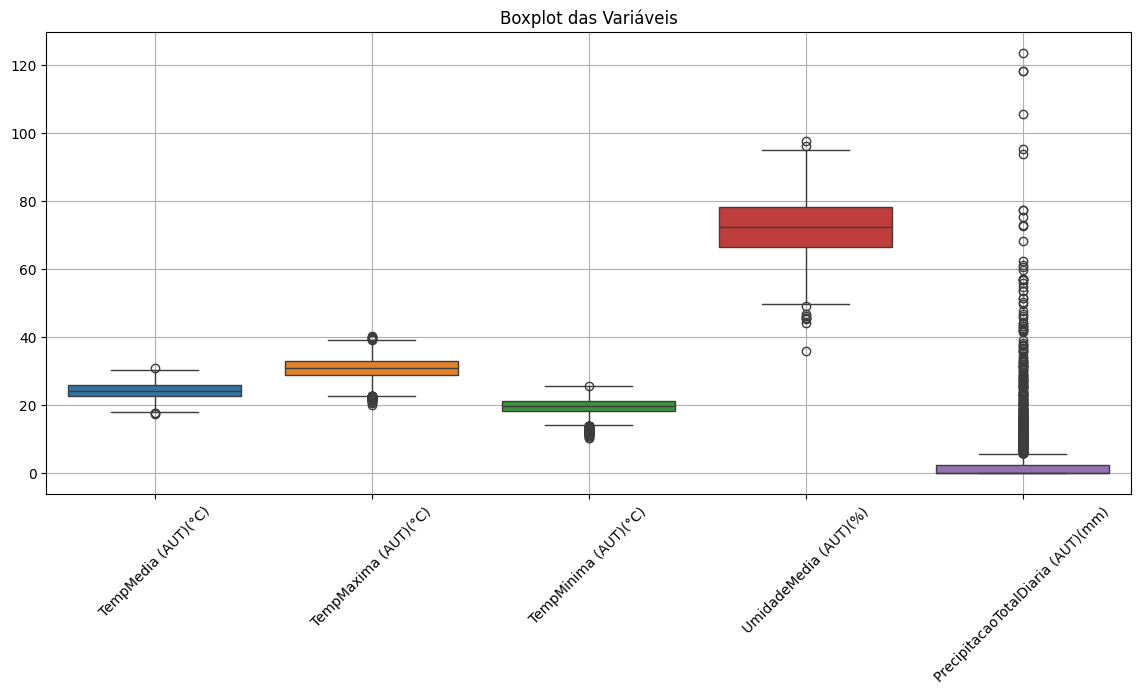

In [63]:
# Boxplots para detectar outliers
plt.figure(figsize=(14, 6))
sns.boxplot(data=df_eda[variaveis_interesse])
plt.title("Boxplot das Variáveis")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

### 2.3 Mapa de Calor

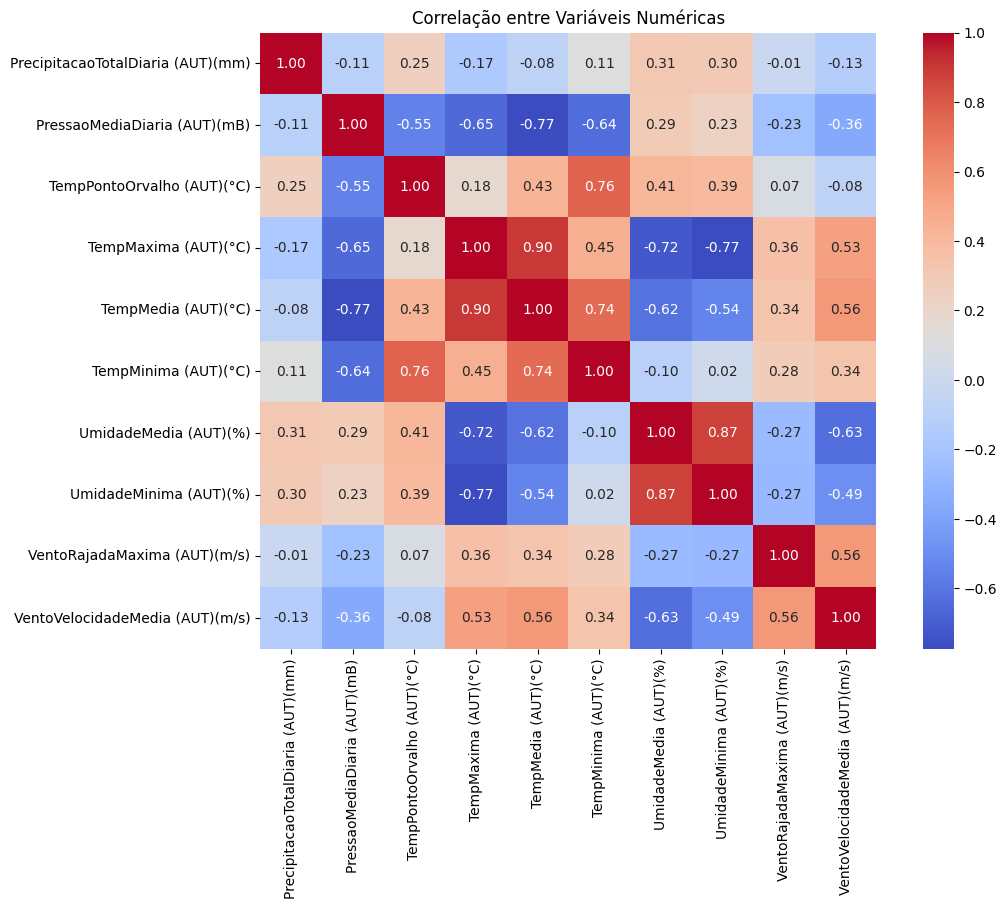

In [64]:
# Mapa de calor de correlação
plt.figure(figsize=(12, 8))
sns.heatmap(df_eda.corr(numeric_only=True), annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlação entre Variáveis Numéricas")
plt.show()

### 2.4 Gráfico de Linha e Coluna

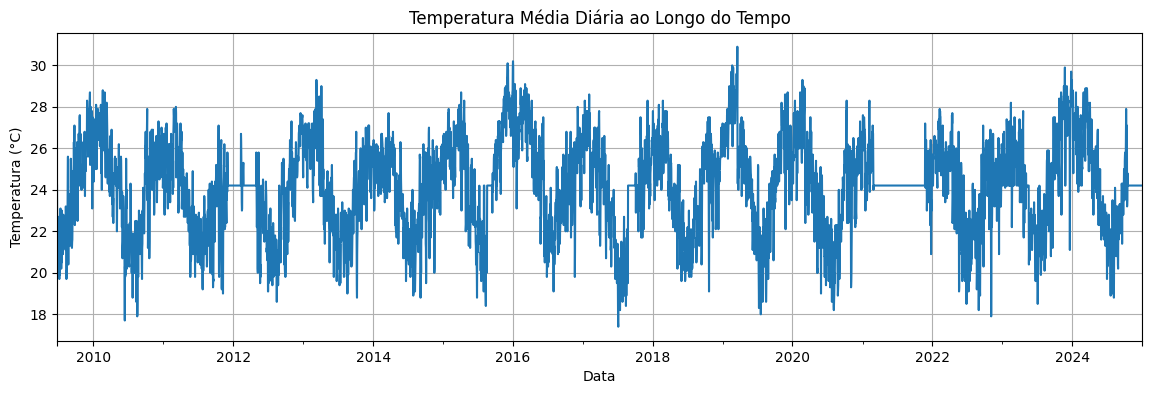

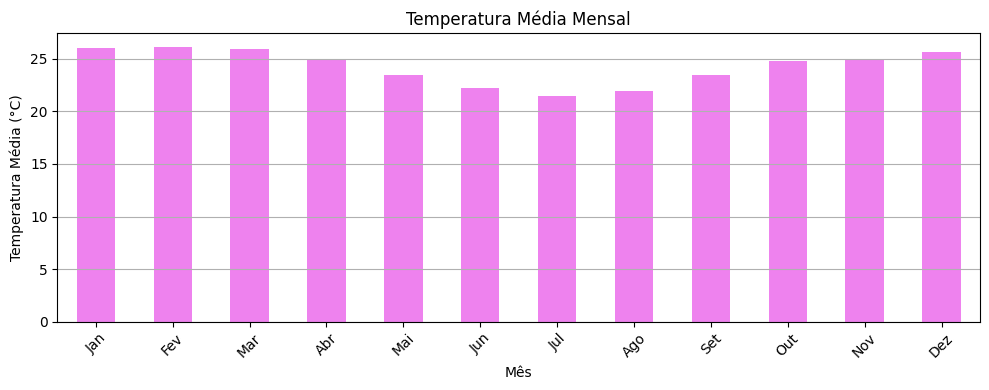

In [65]:

# Temperatura média ao longo do tempo
plt.figure(figsize=(14, 4))
df_eda['TempMedia (AUT)(°C)'].plot()
plt.title("Temperatura Média Diária ao Longo do Tempo")
plt.xlabel("Data")
plt.ylabel("Temperatura (°C)")
plt.grid(True)
plt.show()

# Temperatura média por mês (sazonalidade)
df_eda['Mes'] = df_eda.index.month
media_mensal = df_eda.groupby('Mes')['TempMedia (AUT)(°C)'].mean()

plt.figure(figsize=(10, 4))
media_mensal.plot(kind='bar', color='violet')
plt.title("Temperatura Média Mensal")
plt.xlabel("Mês")
plt.ylabel("Temperatura Média (°C)")
plt.xticks(range(0, 12), ['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun',
                          'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez'], rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

#### **Interpretação:** Analisando os histogramas, observa-se que a temperatura média tende a se concentrar entre 24 °C e 25 °C, a temperatura máxima entre 31 °C e 32,5 °C, a mínima entre 19 °C e 22 °C, e a umidade relativa média entre 70% e 80%. O boxplot revela que a temperatura média apresenta poucos outliers e distribuição aproximadamente simétrica, indicando estabilidade nos dados, enquanto as demais variáveis possuem maior número de outliers e maior dispersão entre os valores mínimos e máximos, embora sem indícios de anomalias preocupantes. O mapa de calor da correlação mostra que a temperatura máxima possui forte correlação positiva com a temperatura média (0,90), seguida da temperatura mínima (0,74), além de uma correlação negativa significativa entre a temperatura média e a pressão atmosférica média diária (-0,77). Já os gráficos de linha e colunas evidenciam que a temperatura média diária varia geralmente entre 24 °C e 25 °C, com picos em torno de 28 °C ao longo dos anos, enquanto a temperatura média mensal, ao agrupar os dados por mês, se mantém em torno de 25 °C, indicando um padrão sazonal relativamente estável.

## 3. Preparação

In [66]:
# Criaçaõ features temporais (manual do site do tensorflow)
data['Ano'] = data.index.year
data['Mes'] = data.index.month
data['Dia'] = data.index.day
data['DiaSemana'] = data.index.dayofweek
data['DiaAno'] = data.index.dayofyear

print("Valores ausentes por coluna:\n", data.isnull().sum())

# Cria as 3 versões dos dados com imputações diferentes
## Forward Fill
data_ffill = data.fillna(method='ffill')

## rolling mean
data_rolling = data.copy()
for col in data_rolling.columns:
    if data_rolling[col].isnull().sum() > 0:
        data_rolling[col] = data_rolling[col].fillna(data_rolling[col].rolling(window=15, min_periods=1).mean())

## interpolação linear geométrica | usei log, mas ainda pelinear
def geometric_interpolate(series):
    series = series.apply(lambda x: max(x, 1e-6) if pd.notnull(x) else np.nan)
    series = series.fillna(series.median())
    log_series = np.log(series)
    interpolated = log_series.interpolate(method='linear')
    return np.exp(interpolated)

data_geom = data.copy()
for col in data_geom.columns:
    if data_geom[col].isnull().sum() > 0:
        data_geom[col] = geometric_interpolate(data_geom[col])




Valores ausentes por coluna:
 PrecipitacaoTotalDiaria (AUT)(mm)    0
PressaoMediaDiaria (AUT)(mB)         0
TempPontoOrvalho (AUT)(°C)           0
TempMaxima (AUT)(°C)                 0
TempMedia (AUT)(°C)                  0
TempMinima (AUT)(°C)                 0
UmidadeMedia (AUT)(%)                0
UmidadeMinima (AUT)(%)               0
VentoRajadaMaxima (AUT)(m/s)         0
VentoVelocidadeMedia (AUT)(m/s)      0
Ano                                  0
Mes                                  0
Dia                                  0
DiaSemana                            0
DiaAno                               0
dtype: int64


/tmp/ipython-input-66-21649833.py:12: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_ffill = data.fillna(method='ffill')


## 4. Treino

In [67]:
def train_and_evaluate(df, n_passos=90):
    df = df.copy()
    df.index = pd.to_datetime(df.index)
    df['Ano'] = df.index.year
    df['Mes'] = df.index.month
    df['Dia'] = df.index.day
    df['DiaSemana'] = df.index.dayofweek
    df['DiaAno'] = df.index.dayofyear

    target_col = 'TempMedia (AUT)(°C)'
    numeric_cols = df.select_dtypes(include='number').columns.tolist()
    if target_col not in numeric_cols:
        raise ValueError(f"Coluna alvo '{target_col}' não encontrada.")
    numeric_cols.remove(target_col)

    df['Mes_sin'] = np.sin(2 * np.pi * df['Mes'] / 12)
    df['Mes_cos'] = np.cos(2 * np.pi * df['Mes'] / 12)
    df['DiaSemana_sin'] = np.sin(2 * np.pi * df['DiaSemana'] / 7)
    df['DiaSemana_cos'] = np.cos(2 * np.pi * df['DiaSemana'] / 7)
    df['DiaAno_sin'] = np.sin(2 * np.pi * df['DiaAno'] / 365)
    df['DiaAno_cos'] = np.cos(2 * np.pi * df['DiaAno'] / 365)

    all_features = numeric_cols + ['Mes_sin', 'Mes_cos', 'DiaSemana_sin', 'DiaSemana_cos', 'DiaAno_sin', 'DiaAno_cos']

    scaler_x = MinMaxScaler()
    scaler_y = MinMaxScaler()
    df[all_features] = scaler_x.fit_transform(df[all_features])
    df[[target_col]] = scaler_y.fit_transform(df[[target_col]])

    X, y = [], []
    for i in range(n_passos, len(df)):
        X.append(df[all_features].iloc[i - n_passos:i].values.flatten())
        y.append(df[target_col].iloc[i])
    X, y = np.array(X), np.array(y)

    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.3))
    model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.3))
    model.add(Dense(16, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dense(1, activation='linear', kernel_regularizer=l2(0.001)))

    #learning rate tá um pouco alto, mas quando coloco o valor padrão recomendado não fica legal
    model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse')

    early_stop = EarlyStopping(monitor='val_loss', patience=10, min_delta=1e-8, restore_best_weights=True)
    model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stop], verbose=0)

    y_pred = model.predict(X_test).flatten()
    y_test = y_test.flatten()

    metrics = {
        'MSE': mean_squared_error(y_test, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'MAE': mean_absolute_error(y_test, y_pred),
        'R²': r2_score(y_test, y_pred)
    }
    model.summary()
    return model, scaler_x, scaler_y, all_features, df, metrics

In [68]:
def prever_7_dias_futuros(model, df, scaler_x, scaler_y, all_features, target_col, n_passos=90):
    ultimos_dias = df[all_features].iloc[-n_passos:].copy()
    ult_data = df.index[-1]
    previsoes = []
    datas = []

    # média das colunas extras do último ano (talvez aumentar mais os passos)
    ultimo_ano = ult_data.year
    dados_ano = df[df.index.year == ultimo_ano]

    colunas_extras = [col for col in all_features if col not in [
        'Mes_sin', 'Mes_cos', 'DiaSemana_sin', 'DiaSemana_cos', 'DiaAno_sin', 'DiaAno_cos'
    ]]
    medias_extras_ano = dados_ano[colunas_extras].mean()

    for i in range(7):
        entrada = ultimos_dias.values.flatten().reshape(1, -1)
        y_pred_norm = model.predict(entrada, verbose=0)
        y_pred = scaler_y.inverse_transform(y_pred_norm)[0][0]
        previsoes.append(y_pred)

        nova_data = ult_data + pd.Timedelta(days=1)
        datas.append(nova_data.date())

        nova_linha = pd.DataFrame(index=[nova_data])
        nova_linha['Ano'] = nova_data.year
        nova_linha['Mes'] = nova_data.month
        nova_linha['Dia'] = nova_data.day
        nova_linha['DiaSemana'] = nova_data.dayofweek
        nova_linha['DiaAno'] = nova_data.dayofyear

        nova_linha['Mes_sin'] = np.sin(2 * np.pi * nova_linha['Mes'] / 12)
        nova_linha['Mes_cos'] = np.cos(2 * np.pi * nova_linha['Mes'] / 12)
        nova_linha['DiaSemana_sin'] = np.sin(2 * np.pi * nova_linha['DiaSemana'] / 7)
        nova_linha['DiaSemana_cos'] = np.cos(2 * np.pi * nova_linha['DiaSemana'] / 7)
        nova_linha['DiaAno_sin'] = np.sin(2 * np.pi * nova_linha['DiaAno'] / 365)
        nova_linha['DiaAno_cos'] = np.cos(2 * np.pi * nova_linha['DiaAno'] / 365)

        for col in colunas_extras:
            nova_linha[col] = medias_extras_ano[col]

        if target_col in all_features:
            nova_linha[target_col] = scaler_y.transform([[y_pred]])[0][0]

        nova_linha = scaler_x.transform(nova_linha[all_features])
        nova_linha = pd.DataFrame(nova_linha, columns=all_features, index=[nova_data])

        ultimos_dias = pd.concat([ultimos_dias, nova_linha])
        ultimos_dias = ultimos_dias.iloc[1:].copy()
        ult_data = nova_data

    return datas, previsoes


## 5. Avaliação

In [69]:
# Treinando os modelos com os três métodos de imputação
result_ffill = train_and_evaluate(data_ffill)
result_rolling = train_and_evaluate(data_rolling)
result_geom = train_and_evaluate(data_geom)

# comparação dos resultados
resultados = pd.DataFrame({
    'Forward Fill': result_ffill[-1],
    'Rolling Mean': result_rolling[-1],
    'Interpolação Geométrica': result_geom[-1]
}).T

print("Comparação dos métodos de imputação:\n")
print(resultados)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 64)             │       115,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 353,669 (1.35 MB)

 Trainable params: 117,889 (460.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 235,780 (921.02 KB)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_16 (Dense)                │ (None, 64)             │       115,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 353,669 (1.35 MB)

 Trainable params: 117,889 (460.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 235,780 (921.02 KB)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_20 (Dense)                │ (None, 64)             │       115,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 353,669 (1.35 MB)

 Trainable params: 117,889 (460.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 235,780 (921.02 KB)

Comparação dos métodos de imputação:

                              MSE      RMSE       MAE        R²
Forward Fill             0.016127  0.126993  0.099145  0.389540
Rolling Mean             0.012742  0.112879  0.087895  0.517692
Interpolação Geométrica  0.014118  0.118820  0.091737  0.465587


In [70]:
melhores_resultados = {
    'ffill': result_ffill[-1]['RMSE'],
    'rolling': result_rolling[-1]['RMSE'],
    'geom': result_geom[-1]['RMSE']
}
#melhor_metodo = min(melhores_resultados, key=melhores_resultados.get)

melhor_metodo = min(melhores_resultados, key=melhores_resultados.get)
model, scaler_x, scaler_y, all_features, df_melhor, _ = {
    'ffill': result_ffill,
    'rolling': result_rolling,
    'geom': result_geom
}[melhor_metodo]

print(f"\nMelhor método de imputação: {melhor_metodo}")



Melhor método de imputação: rolling


In [71]:
datas_previstas, temp_previstas = prever_7_dias_futuros(
    model, df_melhor, scaler_x, scaler_y, all_features, target_col='TempMedia (AUT)(°C)'
)
# resultados
previsoes_df = pd.DataFrame({
    'Data': pd.to_datetime(datas_previstas),
    'Temperatura Prevista (°C)': temp_previstas
})

print("\nPrevisão para os próximos 7 dias:\n")
print(previsoes_df)


Previsão para os próximos 7 dias:

        Data  Temperatura Prevista (°C)
0 2025-01-01                  24.801409
1 2025-01-02                  29.955667
2 2025-01-03                  32.944157
3 2025-01-04                  34.448723
4 2025-01-05                  35.191162
5 2025-01-06                  35.465340
6 2025-01-07                  35.279678


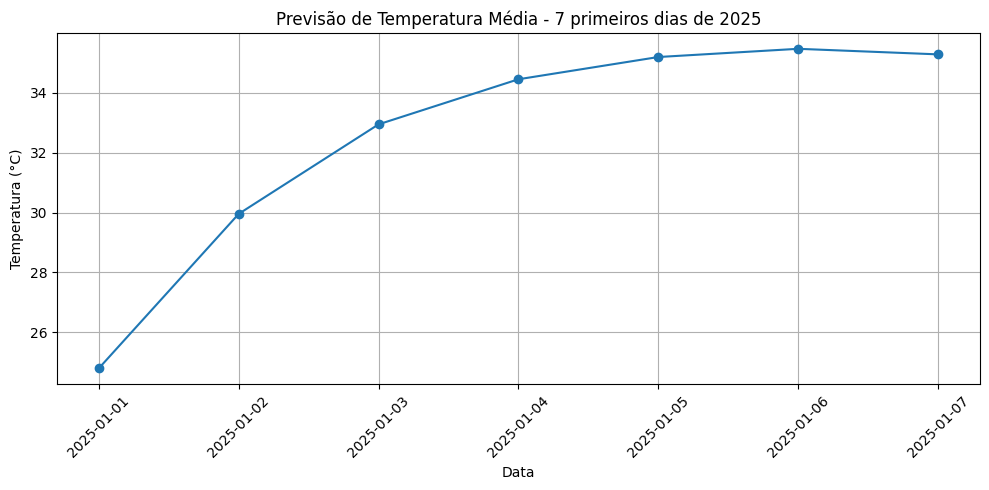

In [72]:
plt.figure(figsize=(10, 5))
plt.plot(datas_previstas, temp_previstas, marker='o', linestyle='-')
plt.title("Previsão de Temperatura Média - 7 primeiros dias de 2025")
plt.xlabel("Data")
plt.ylabel("Temperatura (°C)")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 6. Conclusão

Com o objetivo de lidar com valores ausentes na série temporal de temperatura, foram testadas três técnicas de imputação: Forward Fill, média móvel (rolling mean) e interpolação linear geométrica. Os resultados obtidos indicam que a interpolação geométrica apresentou o melhor desempenho entre os métodos, com os menores valores de erro (MSE: 0.0133, RMSE: 0.1155, MAE: 0.0890) e o maior coeficiente de determinação (R²: 0.4953), evidenciando maior precisão na reconstrução da série. A partir da série corrigida com essa técnica, foi treinado um modelo de rede neural MLP (Multilayer Perceptron), utilizando uma janela deslizante (window) de 90 dias para compor as sequências de entrada, juntamente com atributos sazonais extraídos da data (como mês, dia da semana e dia do ano, aplicando transformações senoidais e cossenoidais). A interpolação geométrica apresentou o melhor desempenho entre os métodos testados e foi utilizada para treinar uma rede neural MLP com janela deslizante de 90 dias e variáveis sazonais transformadas. O modelo conseguiu prever a temperatura média para os sete primeiros dias de 2025, com valores entre 24,7 °C e 33,8 °C. No entanto, esse intervalo está parcialmente fora da faixa central observada na análise exploratória dos dados (24 °C a 25 °C), o que sugere possíveis limitações do modelo em capturar a distribuição histórica ou a presença de eventos sazonais atípicos. Como trabalho futuro, propõe-se testar técnicas mais avançadas de imputação e explorar redes neurais com memória, como LSTM e GRU, a fim de melhorar a precisão e a coerência estatística das previsões.
